In [1]:
import multiprocessing as mp
import os
import random as rn
import warnings
from glob import glob
from pathlib import Path

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timesynth as ts
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    rn.seed(seed)
    np.random.seed(seed)

In [2]:
data_name = "temperature_multi"

Index(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston'],
      dtype='object')
(11116, 31) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston
0,2012-10-01 12:00:00,284.628680,282.085039,289.471870,281.795683,291.867010,291.535619,293.401773,296.613332,285.169503,...,284.091251,298.224942,288.650251,299.739699,281.037695,286.264020,285.683344,288.264872,285.837480,287.195921
1,2012-10-01 16:00:00,284.621889,282.113403,289.424681,281.771373,291.849492,291.567990,293.364767,296.688934,285.432435,...,284.434403,298.535509,288.651605,299.851734,281.247197,286.286962,285.990865,288.525098,285.880639,287.345620
2,2012-10-01 20:00:00,284.613716,282.147861,289.367183,281.741836,291.828128,291.607407,293.320910,296.780850,285.750009,...,284.851105,298.912970,288.653243,299.987981,281.501403,286.314872,286.365330,288.842152,285.933197,287.527938
3,2012-10-02 00:00:00,284.605542,282.182319,289.309684,281.712300,291.806763,291.646823,293.277053,296.872765,286.067582,...,285.267807,299.290432,288.654881,300.124228,281.755608,286.342782,286.739796,289.159206,285.985755,287.710256
4,2012-10-02 04:00:00,284.597369,282.216777,289.252185,281.682764,291.785399,291.686240,293.233196,296.964680,286.385156,...,285.684509,299.667894,288.656519,300.260475,282.009813,286.370692,287.114261,289.476260,286.038314,287.892574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11111,2017-10-27 08:00:00,281.125000,283.865000,287.972500,281.077500,291.277500,288.645000,291.167500,291.950000,278.735000,...,282.507500,283.117500,278.097500,291.415000,276.202500,276.292500,276.745000,278.710000,280.640000,280.867500
11112,2017-10-27 12:00:00,280.060000,282.570000,285.672500,280.800000,289.182500,286.507500,288.310000,289.365000,275.692500,...,284.192500,287.757500,281.927500,293.852500,281.467500,279.690000,281.327500,282.392500,279.137500,282.252500
11113,2017-10-27 16:00:00,282.712500,287.875000,290.917500,282.657500,294.552500,293.317500,295.477500,296.660000,281.345000,...,287.000000,295.895000,293.620000,299.760000,292.032500,285.215000,288.900000,288.877500,281.715000,287.860000
11114,2017-10-27 20:00:00,287.845000,294.812500,299.455000,288.580000,301.167500,300.005000,299.807500,303.807500,285.887500,...,283.712500,296.115000,293.665000,299.445000,293.362500,287.580000,288.895000,288.302500,282.532500,287.962500


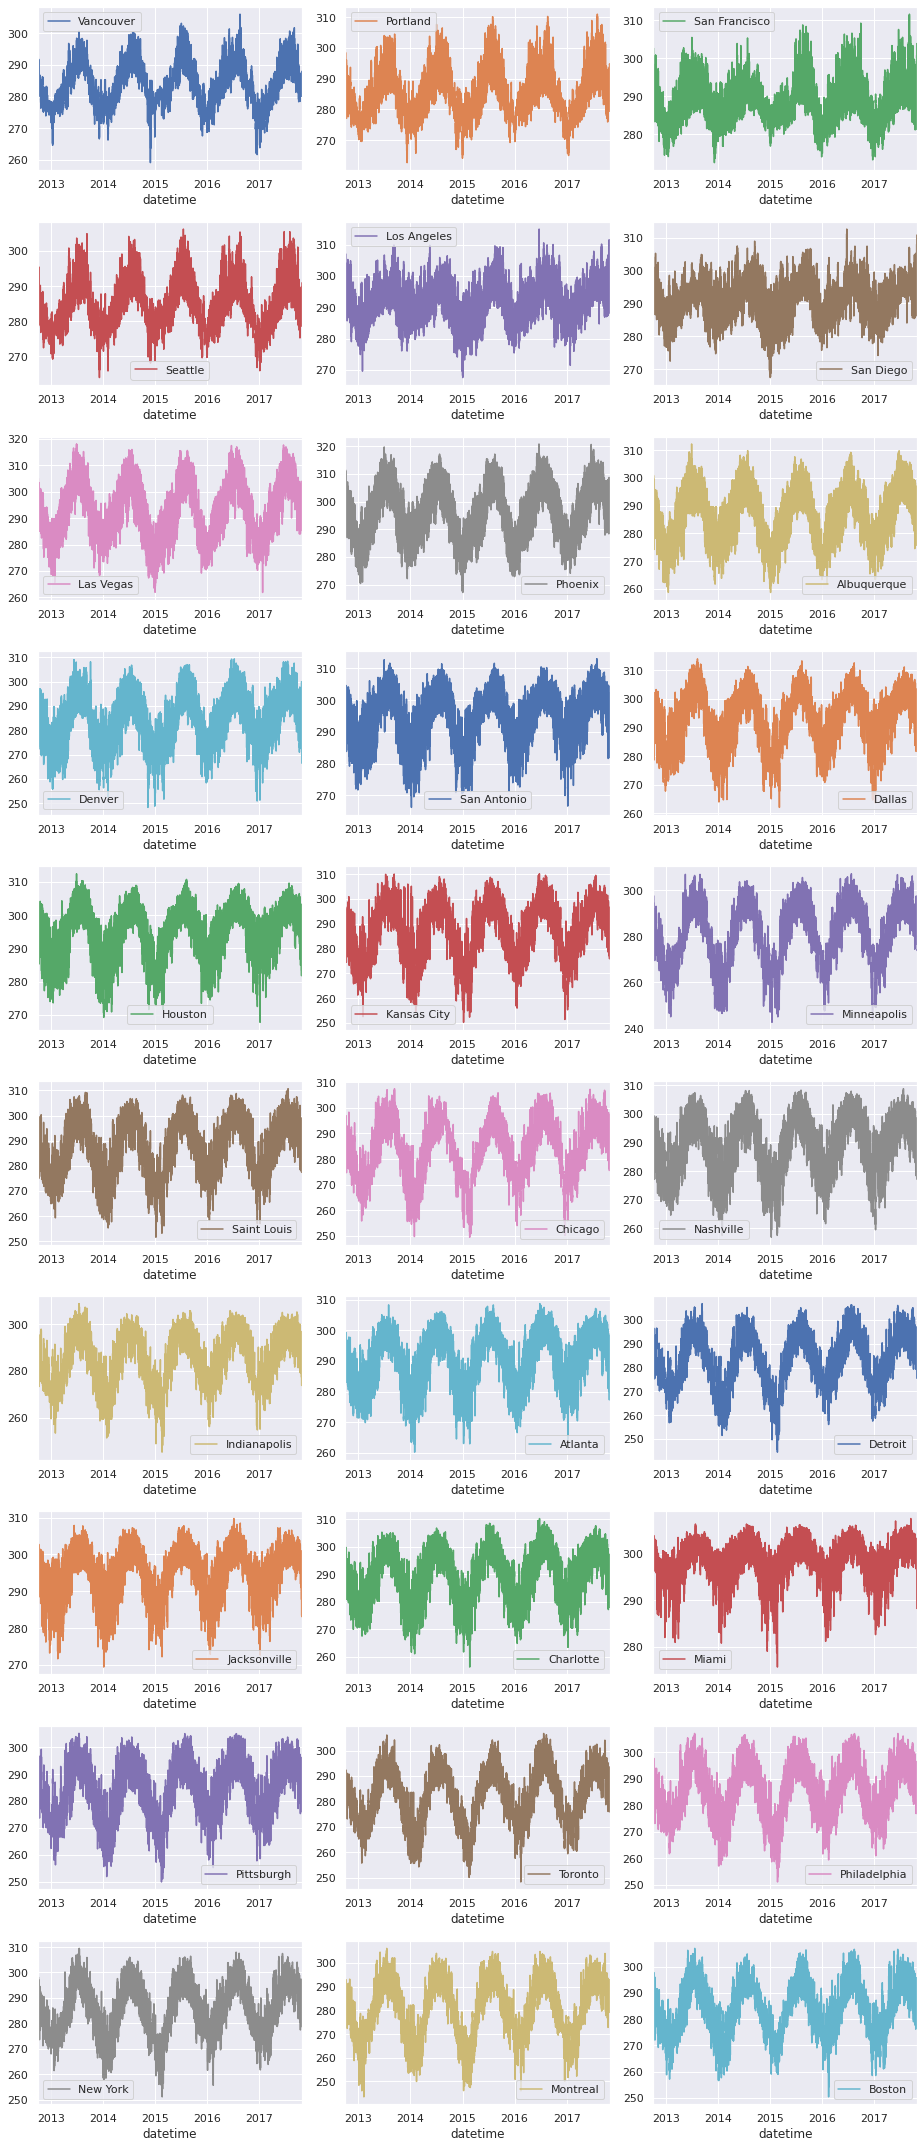

In [3]:
if data_name == "nyc_taxi":
    data_path = "data/nyc_taxi.csv"
    dt, target = "timestamp", "value"
    data = pd.read_csv(data_path)
    data[dt] = pd.to_datetime(data[dt])
elif data_name == "temperature":
    data_path = "data/temperature.csv"
    dt, target = "datetime", "Montreal"
    data = pd.read_csv(data_path)[[dt, target]][1:-792]
    data[dt] = pd.to_datetime(data[dt])
    data = data.set_index(dt).resample("4h").mean().interpolate(limit_area="inside").reset_index()
elif data_name == "temperature_multi":
    data_path = "data/temperature_multi.csv"
    dt, target = "datetime", "Montreal"
    data = pd.read_csv(data_path).drop(["Beersheba", "Tel Aviv District", "Eilat", "Haifa",
                                        "Nahariyya", "Jerusalem"], axis=1)[1:-792]
    data[dt] = pd.to_datetime(data[dt])
    data = data.set_index(dt).resample("4h").mean().interpolate(limit_area="inside").reset_index()

print(data.columns)
print(data.shape, data.isna().sum().values)
# print(data.drop(dt, axis=1).apply(np.std).sort_values())

display(data)
# data.set_index(dt).plot(figsize=(13, 4))
data.set_index(dt).plot(subplots=True, layout=(10, 3), figsize=(13, 3*10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

In [4]:
n_levels = 6
target_mean = data[target].mean()
target_std = data[target].std()

# data_fault_type = "white_noise"
# data_fault_type = "red_noise"
# data_fault_type = "outliers"
data_fault_type = "stuck-at"

# data_fault_params = dict(zip(np.arange(n_levels), target_std * np.linspace(0, 3.5, num=n_levels)))
# data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, 4, num=n_levels)))
# data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, .075, num=n_levels)))
data_fault_params = dict(zip(np.arange(n_levels), np.arange(n_levels)))

n_test = np.round(.2*len(data)).astype(int)
n_train = len(data)-n_test
n_train, n_test

(8893, 2223)

In [5]:
def inject_white_noise(data, std):
    data_ = data.copy()
    data_[target] += ts.noise.GaussianNoise(std=std).sample_vectorized(data.index.values)
    return data_

def inject_red_noise(data, tau, std):
    data_ = data.copy()
    dummy_signal = ts.signals.Sinusoidal(frequency=0)
    noise_generator = ts.noise.RedNoise(std=std, tau=tau)
    timeseries = ts.TimeSeries(dummy_signal, noise_generator=noise_generator)
    data_[target] += timeseries.sample(data.index)[0]
    return data_

def inject_outliers(data, prob, mean, std):
    data_ = data.copy()
    n_outliers = np.round(prob*len(data)).astype(int)
    n_train_outliers = np.round(prob*n_train).astype(int)
    n_test_outliers = n_outliers-n_train_outliers
    train_outlier_idxs = rn.sample(range(n_train), n_train_outliers)
    test_outlier_idxs = rn.sample(range(n_train, len(data)), n_test_outliers)
    outlier_idxs = np.concatenate((train_outlier_idxs, test_outlier_idxs))
    data_[target][outlier_idxs] = 10 * std + mean
    return data_

def inject_stuck_at(data, level, mean, std):
    data_ = data.copy()
    if level == 0:
        data_[target] = data_[target].astype(float)
        return data_
    n_stuck_at = n_train // (n_levels - 1)
    start = (level - 1) * n_stuck_at
    end = start + n_stuck_at
    data_[target][start:end] = 10 * std + mean
    return data_

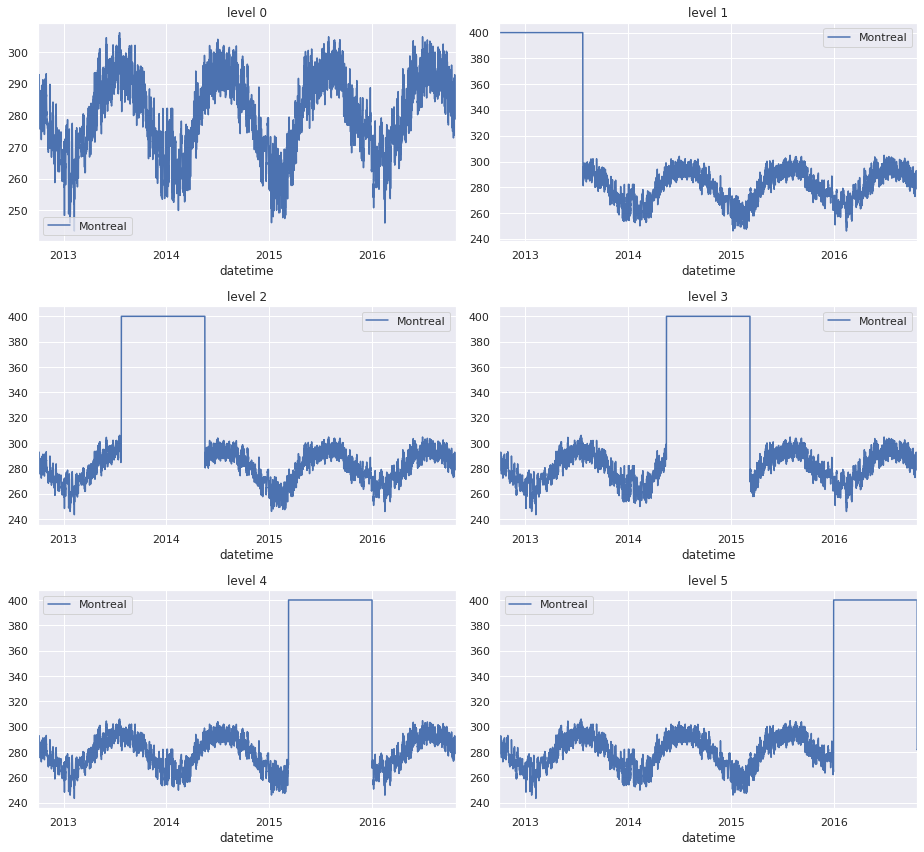

In [6]:
reset_seed()

n_subplot_rows = n_levels//2 if n_levels % 2 == 0 else n_levels//2+1
train_dfs, test_dfs, pred_dfs = dict(), dict(), dict()

fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(13, 4*n_subplot_rows))
for i in data_fault_params.keys():
    data_ = None
    if data_fault_type == "white_noise":
        data_ = inject_white_noise(data, data_fault_params[i])
    elif data_fault_type == "red_noise":
        data_ = inject_red_noise(data, data_fault_params[i], target_std)
    elif data_fault_type == "outliers":
        data_ = inject_outliers(data, data_fault_params[i], target_mean, target_std)
    elif data_fault_type == "stuck-at":
        data_ = inject_stuck_at(data, data_fault_params[i], target_mean, target_std)
    
    df_train, df_test = train_test_split(data_, shuffle=False, test_size=n_test)
    train_dfs[i] = df_train
    test_dfs[i] = df_test.reset_index(drop=True)

    train_dfs[i].plot(x=dt, y=target, ax=axes.flatten()[i], sharex=False, sharey=False,
                      title=f"level {i}")

    train_path = f"train/{Path(data_path).stem}_{data_fault_type}_level_{i}.csv"
    if not Path(train_path).exists():
        train_dfs[i].to_csv(train_path, index=False)
    else:
        train_df = pd.read_csv(train_path)
        assert np.allclose(train_df[target].values, train_dfs[i][target].values)
plt.tight_layout()
plt.show()

In [7]:
automl_names = ["analytics-zoo", "prophet_iterative"]
time_limit_min = 360

In [8]:
for automl_name in automl_names:
    pred_dfs[automl_name] = dict()
    for i in range(len(data_fault_params)):
        pred_dfs[automl_name][i] = list()
        pred_paths = glob(f"pred/{Path(data_path).stem}_{data_fault_type}_level_{i}_" \
                          f"{automl_name}_{time_limit_min}_min_*.csv")
        for pred_path in sorted(pred_paths):
            df_pred = pd.read_csv(pred_path)
            df_pred.name = pred_path[-12:-4]
            df_pred[dt] = pd.to_datetime(df_pred[dt])
            pred_dfs[automl_name][i].append(df_pred)

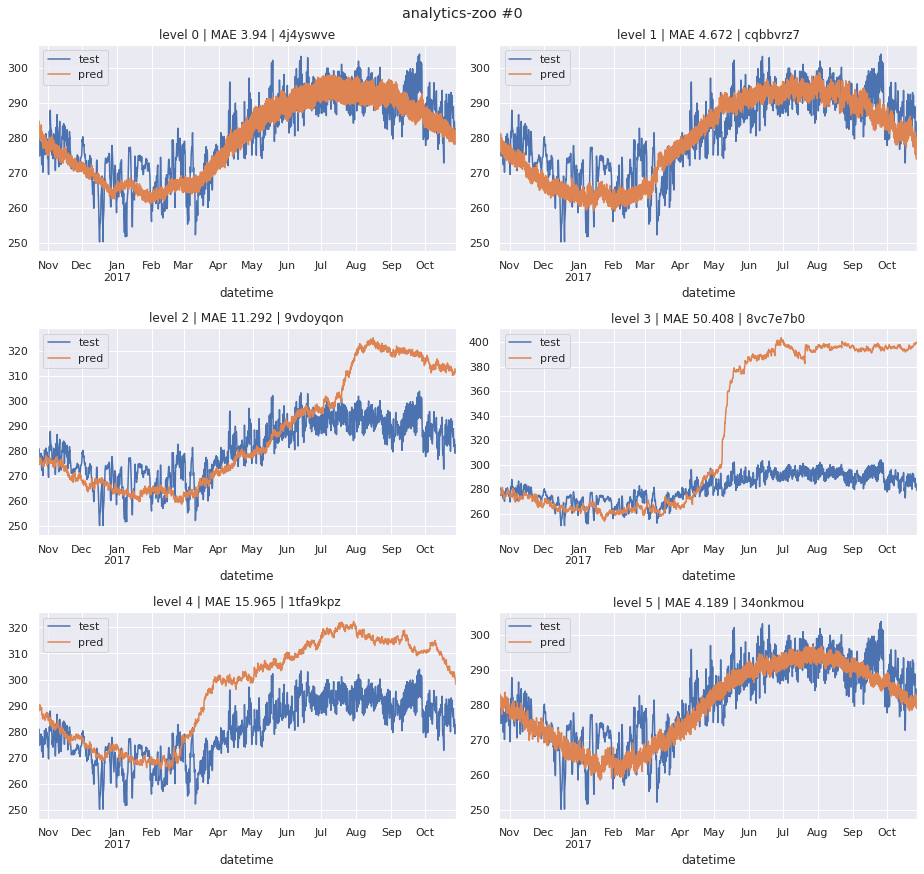

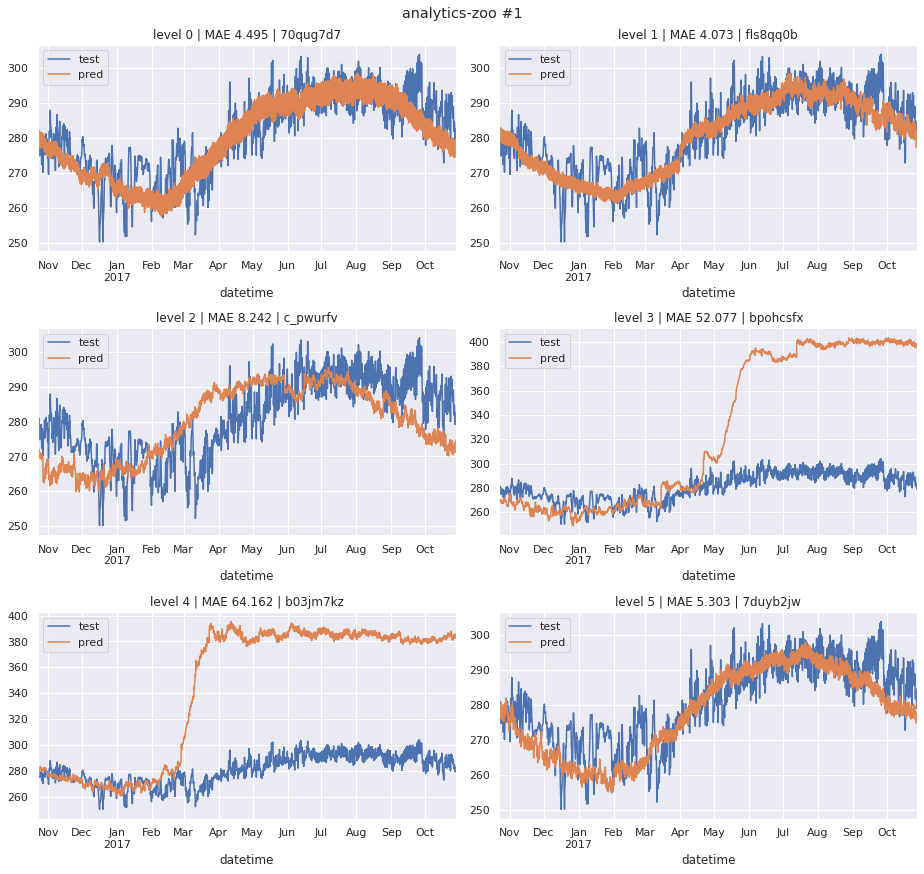

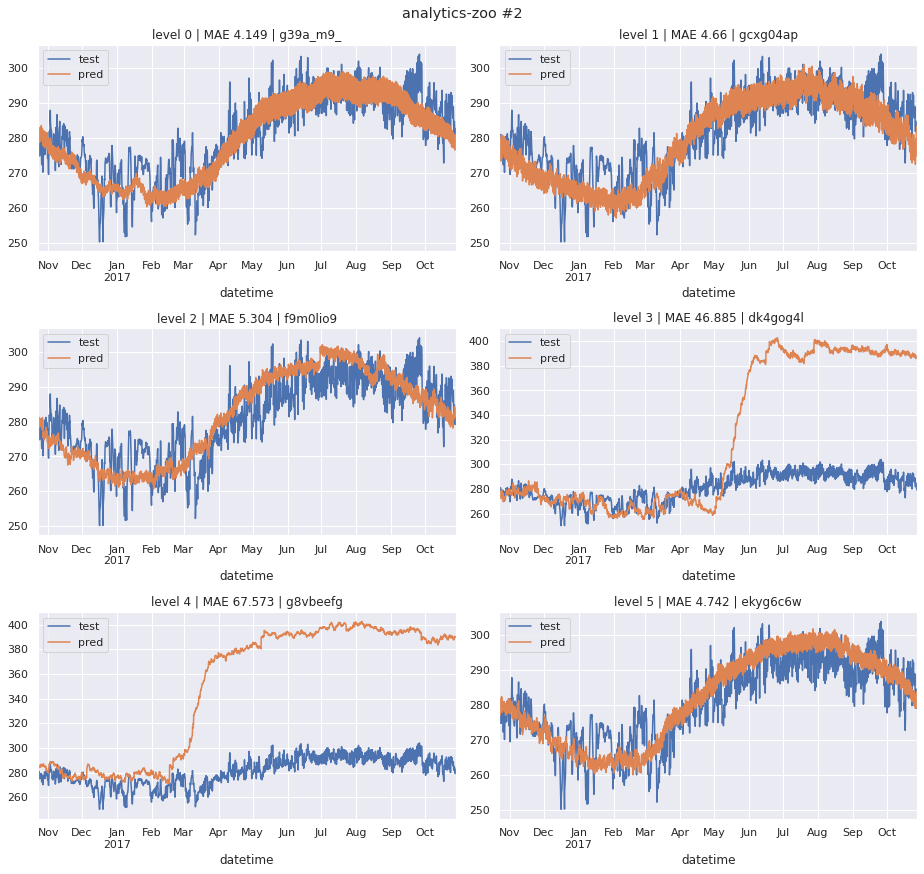

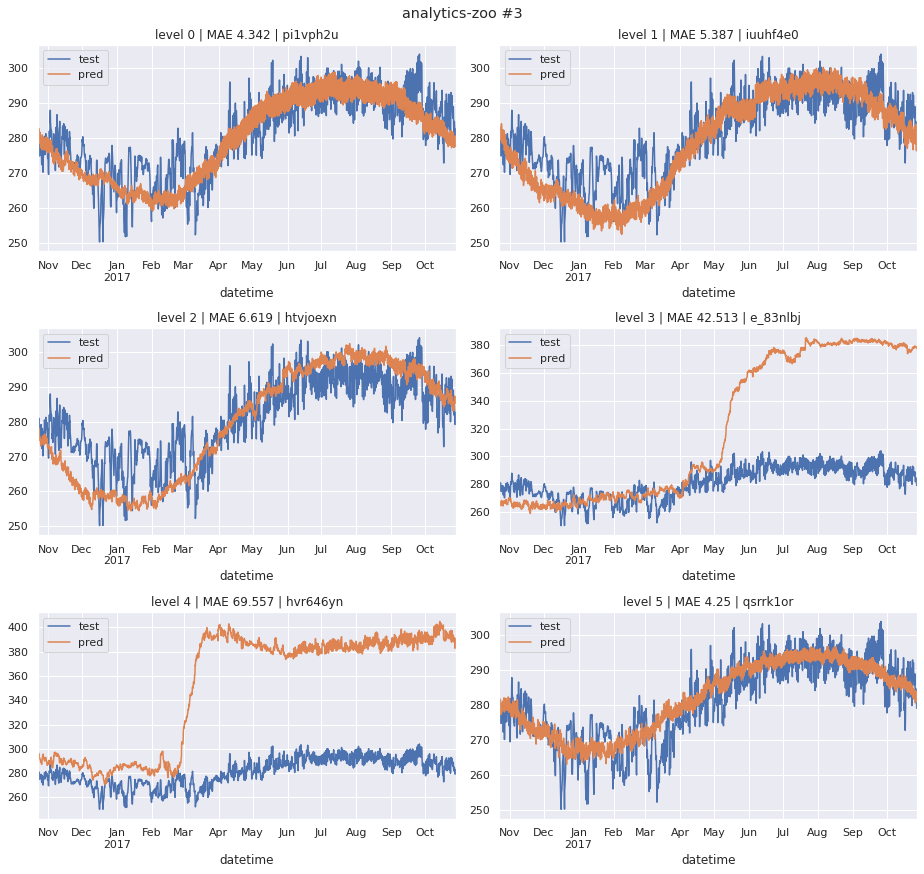

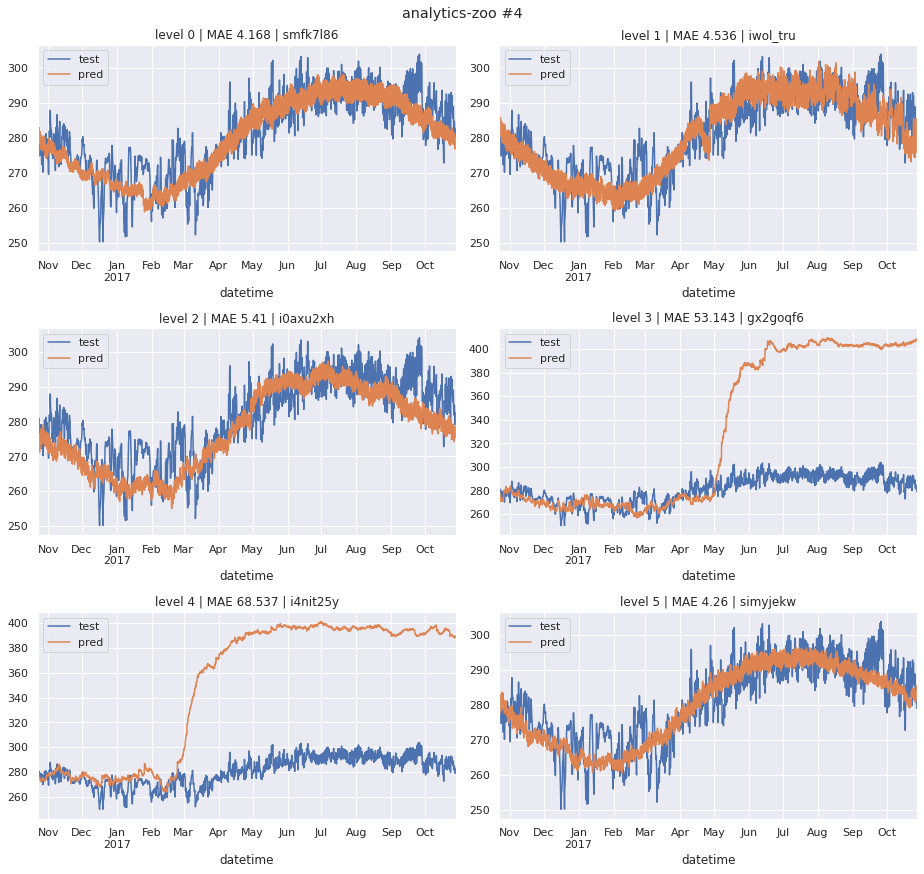

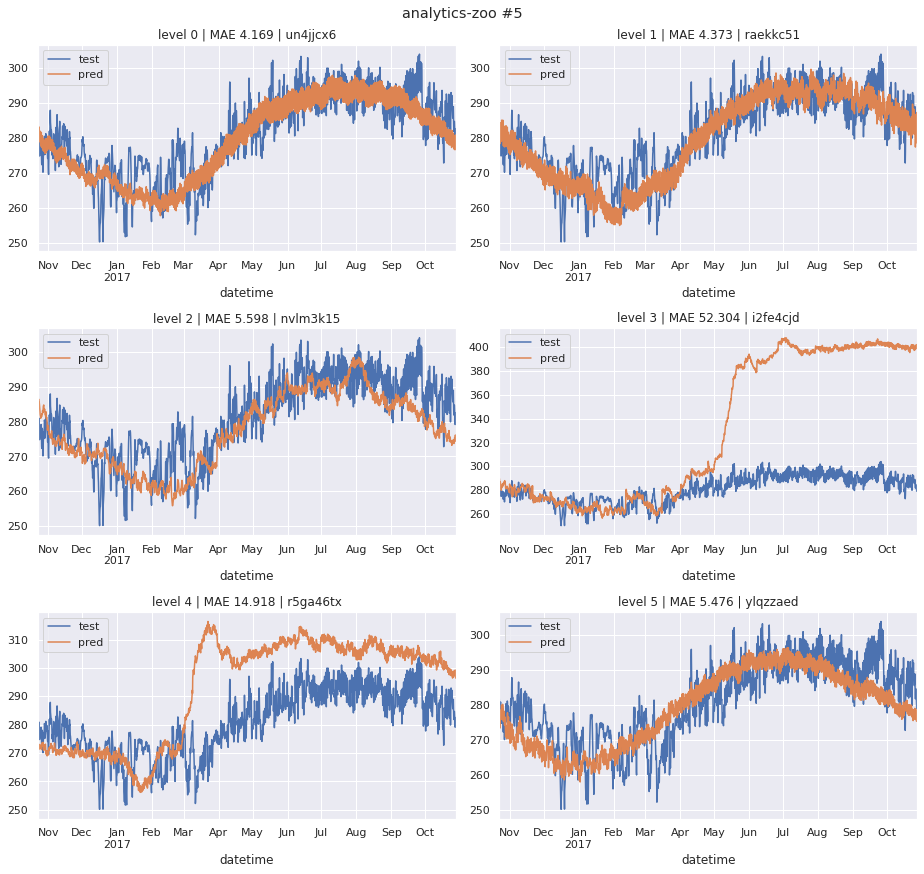

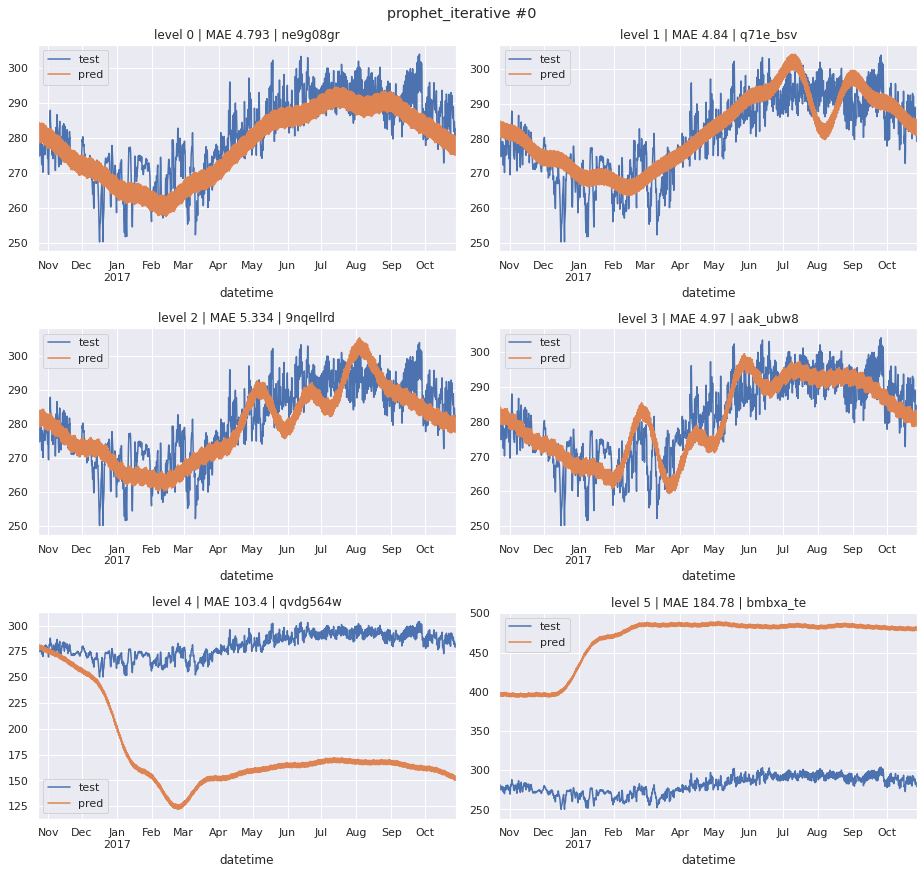

In [9]:
df_test = test_dfs[0]
results = []
for automl_name in automl_names:
    max_len = max([len(v) for v in pred_dfs[automl_name].values()])
    for i in range(max_len):
        if automl_name == "prophet" and i:
            break
        fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(13, 4*n_subplot_rows))
        for j in data_fault_params.keys():
            try:
                df_pred = pred_dfs[automl_name][j][i]
            except:
                continue
            mae = mean_absolute_error(df_test[target], df_pred[target])
            results.append({"automl_name": automl_name, "level": j, "MAE": mae})
            df = pd.DataFrame({dt: df_test[dt], "test": df_test[target], "pred": df_pred[target]})
            df.name = automl_name
            df.plot(x=dt, ax=axes.flatten()[j], sharex=False, sharey=False,
                    title=f"level {j} | MAE {np.round(mae, 3)} | {df_pred.name}")
        plt.tight_layout()
        plt.suptitle(f"{automl_name} #{i}", y=1.01)
        plt.show()

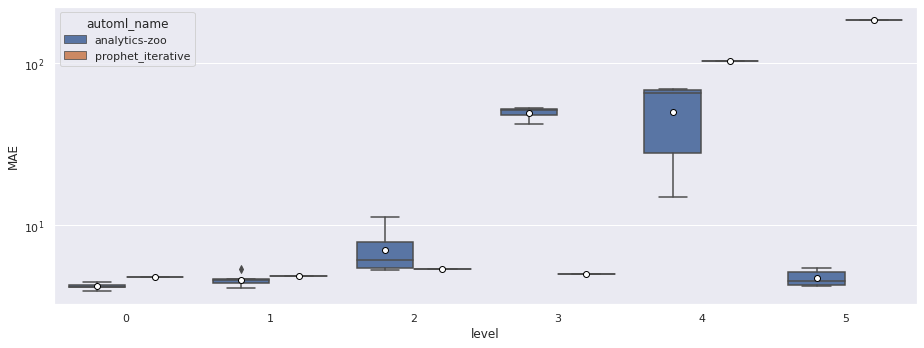

In [10]:
df_results = pd.DataFrame(results)
sns.set(rc={"figure.figsize": (13, 5)})
g = sns.boxplot(x="level", y="MAE", hue="automl_name", showmeans=True, data=df_results,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black",
                      "markersize":"6"})
g.set(yscale="log")
plt.tight_layout()
plt.show()

In [11]:
df = df_results.groupby(["level", "automl_name"])["MAE"].aggregate(["mean", "count"]).unstack()
df = df[["mean", "count"]]
display(df.round(decimals=6))

mean                           count                  
automl_name analytics-zoo prophet_iterative analytics-zoo prophet_iterative
level                                                                      
0                4.210467          4.792863             6                 1
1                4.616878          4.839601             6                 1
2                7.077520          5.334051             6                 1
3               49.555050          4.969960             6                 1
4               50.118792        103.400399             6                 1
5                4.703166        184.780244             6                 1